In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dysts.flows import Lorenz
from matplotlib.collections import LineCollection

In [2]:
sys = Lorenz()
traj = sys.make_trajectory(1024)

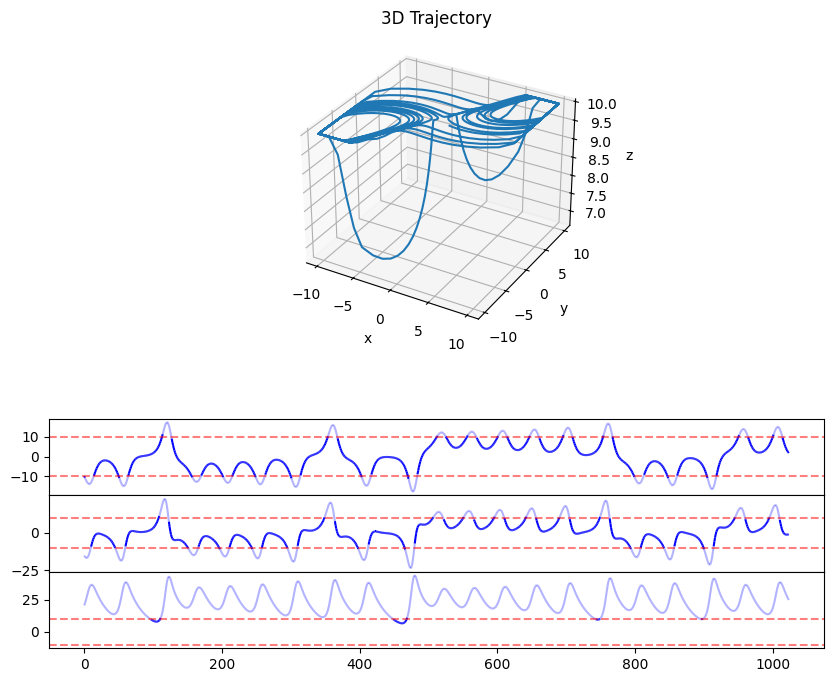

In [3]:
def plot_trajectory_with_coords(traj: np.ndarray, clip: float = None) -> None:
    """Plot 3D trajectory and individual coordinates.

    Args:
        traj: Trajectory array of shape (T, 3)
        clip: Optional float to clamp trajectory values between [-clip, clip]
    """
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 3], hspace=0.3)

    # Create clipped trajectory if clip is provided
    if clip is not None:
        clipped_traj = np.clip(traj, -clip, clip)
    else:
        clipped_traj = traj

    # Top subplot - 3D trajectory
    ax1 = fig.add_subplot(gs[0], projection="3d")
    ax1.plot(clipped_traj[:, 0], clipped_traj[:, 1], clipped_traj[:, 2])
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("z")
    ax1.set_title("3D Trajectory")

    # Bottom row - individual coordinates with shared x axis
    t = np.arange(len(traj))
    gs_bot = gs[1].subgridspec(3, 1, hspace=0)
    axes = []

    # For each coordinate, plot full range and clipped version if clip provided
    for i, (ax, label) in enumerate(
        [(gs_bot[0], "x"), (gs_bot[1], "y"), (gs_bot[2], "z")]
    ):
        ax_i = fig.add_subplot(ax, sharex=axes[0] if i > 0 and axes else None)
        axes.append(ax_i)
        coord = traj[:, i]

        if clip is not None:
            # Plot the full trajectory once, with alpha varying based on clipping
            alpha = np.where((coord > clip) | (coord < -clip), 0.3, 1.0)

            # Create line segments with varying alpha
            points = np.array([t, coord]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            # Create line collection with per-segment alpha
            lc = LineCollection(segments, colors="blue", alpha=alpha[:-1])
            ax_i.add_collection(lc)
            ax_i.autoscale()

            # Add clip boundary lines
            ax_i.axhline(y=clip, color="r", linestyle="--", alpha=0.5)
            ax_i.axhline(y=-clip, color="r", linestyle="--", alpha=0.5)
        else:
            ax_i.plot(t, coord, color="blue")


plot_trajectory_with_coords(traj, clip=10)


In [4]:
from matplotlib.animation import FuncAnimation


def animate_clipping(
    traj: np.ndarray,
    clip_range: tuple[float, float] = (1, 20),
    duration_sec: float = 5.0,
    fps: int = 30,
) -> FuncAnimation:
    """Animate trajectory visualization with continuously oscillating clip values."""
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 3], hspace=0.3)

    # Setup static plot elements
    ax3d = fig.add_subplot(gs[0], projection="3d")
    ax3d.set_xlabel("x")
    ax3d.set_ylabel("y")
    ax3d.set_zlabel("z")
    ax3d.set_title("3D Trajectory")

    gs_bot = gs[1].subgridspec(3, 1, hspace=0)
    coord_axes = []
    t = np.arange(len(traj))

    # Setup 2D plots
    for i, label in enumerate(["x", "y", "z"]):
        ax = fig.add_subplot(
            gs_bot[i], sharex=coord_axes[0] if i > 0 and coord_axes else None
        )
        coord_axes.append(ax)

    title = fig.suptitle("")

    # Prepare animation frames
    n_frames = int(duration_sec * fps)
    forward = np.linspace(*clip_range, n_frames)
    reverse = np.linspace(clip_range[1], clip_range[0], n_frames)
    clip_values = np.concatenate([forward, reverse])
    frames_per_cycle = len(clip_values)
    total_frames = frames_per_cycle * 2

    # Initialize plot objects
    line3d = ax3d.plot([], [], [])[0]
    coord_lines = []
    clip_lines = []

    for ax in coord_axes:
        coord_lines.append(ax.add_collection(LineCollection([], colors="blue")))
        clip_lines.extend(
            [
                ax.axhline(y=0, color="r", linestyle="--", alpha=0.5),
                ax.axhline(y=0, color="r", linestyle="--", alpha=0.5),
            ]
        )
        ax.autoscale()

    # Set axis limits once
    ax3d.set_xlim(np.min(traj[:, 0]), np.max(traj[:, 0]))
    ax3d.set_ylim(np.min(traj[:, 1]), np.max(traj[:, 1]))
    ax3d.set_zlim(np.min(traj[:, 2]), np.max(traj[:, 2]))

    for i, ax in enumerate(coord_axes):
        ax.set_ylim(np.min(traj[:, i]) * 1.1, np.max(traj[:, i]) * 1.1)
        ax.set_xlim(0, len(traj))

    def update(frame: int) -> tuple:
        current_frame = frame % total_frames
        clip = clip_values[current_frame]

        # Update 3D plot
        clipped_traj = np.clip(traj, -clip, clip)
        line3d.set_data(clipped_traj[:, 0], clipped_traj[:, 1])
        line3d.set_3d_properties(clipped_traj[:, 2])

        # Update 2D plots
        for i, line_collection in enumerate(coord_lines):
            coord = traj[:, i]
            alpha = np.where((coord > clip) | (coord < -clip), 0.3, 1.0)
            points = np.array([t, coord]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            line_collection.set_segments(segments)
            line_collection.set_alpha(alpha[:-1])

        # Update clip lines
        for line in clip_lines[::2]:
            line.set_ydata([clip, clip])
        for line in clip_lines[1::2]:
            line.set_ydata([-clip, -clip])

        title.set_text(f"Clip Value: {clip:.1f}")
        return (line3d, *coord_lines, *clip_lines, title)

    anim = FuncAnimation(
        fig,
        update,
        frames=total_frames,  # Finite number of frames
        interval=1000 / fps,
        blit=True,
        save_count=total_frames,  # Explicitly set save_count
    )
    return anim

/tmp/ipykernel_1680790/3320079607.py:93: UserWarning: You passed in an explicit save_count=600 which is being ignored in favor of frames=600.
  anim = FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: index 300 is out of bounds for axis 0 with size 300

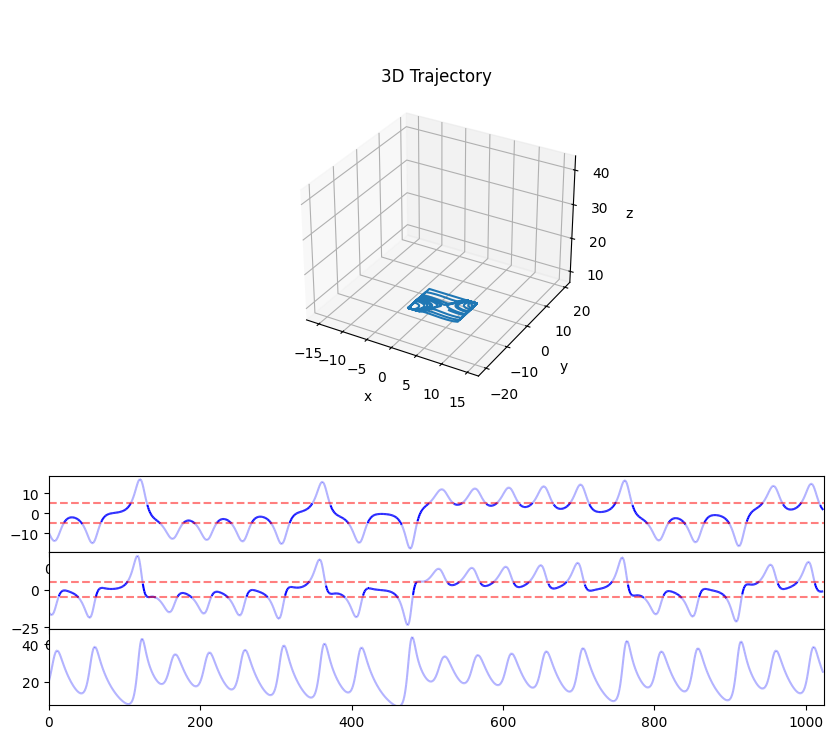

In [5]:
# Create and display animation
anim = animate_clipping(traj)
# To save animation (for a finite number of cycles):
anim.save("clipping_animation.gif")